## In this notebook I have the done the following operations:

1. Merging the two provided datasets for predicting chances of deal_closing using Text transcripts from conversations between Sales agents and customers.

2. Building a Text Classifier using numeric features as well using a Logistic Regression model using Hyperparameter tuning and different vectorizers( BOW and TFIDF )

3. Using a Logistic Regression by applying L1 and L2 penalty for better predictions and convergence.
#### All the observations have been documented

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns

In [5]:
df = pd.read_csv('clean_sales.csv', index_col=0)
df.head()

,Deal_Stage,Close_Value,DateDiff,Extracted Interaction Text,Ordered_Agent,Ordered_Product
0,1,4639,635,letter response request weekly progress report...,12,3
1,0,588,725,sorry unable help individual tax return past y...,17,5
2,0,1026,401,gives immense pleasure write regard offer mark...,11,5
3,1,5068,29,iop corporation commence reduction work force ...,9,3
4,0,492,563,want compliment one excellent employees julie ...,27,5


In [19]:
from sklearn.preprocessing import RobustScaler
import sqlite3
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import classification_report
from prettytable import PrettyTable

In [7]:
X = df['Extracted Interaction Text']
y = df['Deal_Stage']

In [8]:
from sklearn.model_selection import train_test_split
X_Train, X_test, y_Train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

X_train, X_cross, y_train, y_cross = train_test_split(X_Train, y_Train, test_size=0.1, random_state=42, shuffle=True)

In [18]:
from sklearn.linear_model import LogisticRegression

# Bag of Words

In [19]:
count= CountVectorizer()

In [20]:
count.fit(X_train)
Train_BOW = count.transform(X_train)
CrossVal_BOW = count.transform(X_cross)
Test_BOW= count.transform(X_test)

In [21]:
#Logistic Regression using BOW on only text feature

In [24]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000]
Train_AUC_BOW = []
CrossVal_AUC_BOW = []
for i in c:
  logreg = LogisticRegression(C=i)
  logreg.fit(Train_BOW, y_train)
  Train_y_pred =  logreg.predict_proba(Train_BOW)[:,1]
  Train_AUC_BOW.append(roc_auc_score(y_train,Train_y_pred))
  CrossVal_y_pred =  logreg.predict_proba(CrossVal_BOW)[:,1]
  CrossVal_AUC_BOW.append(roc_auc_score(y_cross,CrossVal_y_pred))

In [25]:
C=[]
for i in range(len(c)):
  C.append(np.math.log(c[i]))

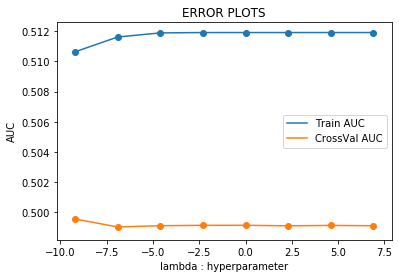

In [26]:
plt.plot(C, Train_AUC_BOW, label='Train AUC')
plt.scatter(C, Train_AUC_BOW)
plt.plot(C, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.scatter(C, CrossVal_AUC_BOW)
plt.legend()
plt.xlabel("lambda : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [28]:
optimal_inverse_lambda=c[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print(optimal_inverse_lambda)

0.0001


In [30]:
Classifier=LogisticRegression(C=optimal_inverse_lambda)
Classifier.fit(Train_BOW,y_train)
Train_FPR, Train_TPR, Thresholds = roc_curve(y_train, Classifier.predict_proba(Train_BOW)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(y_test, Classifier.predict_proba(Test_BOW)[:,1])

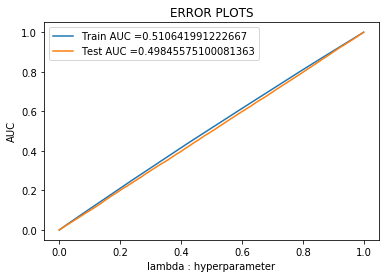

In [31]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.legend()
plt.xlabel("lambda : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [32]:
y_pred = Classifier.predict(Test_BOW)

In [33]:
print(confusion_matrix(y_test, y_pred))
print('Accuracy of our model is: ', accuracy_score(y_test, y_pred))

[[    0 52124]
 [    0 88696]]
Accuracy of our model is:  0.629853713961085


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     52124
           1       0.63      1.00      0.77     88696

    accuracy                           0.63    140820
   macro avg       0.31      0.50      0.39    140820
weighted avg       0.40      0.63      0.49    140820



C:\Users\SIDDHARTH\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
feature_names = count.get_feature_names()
prob_sorted = sorted(zip(Classifier.coef_[0], feature_names))
print("Top 10 negative class words")
print(prob_sorted[:10])
print("Top 10 positive class words")
print(prob_sorted[:-(11):-1])

Top 10 negative class words
[(-0.008777004626901076, 'begin'), (-0.007930378974487251, 'last'), (-0.007180138126354252, 'however'), (-0.006905575634971576, 'ideas'), (-0.006728467759182713, 'working'), (-0.006590983913964734, 'soon'), (-0.0060358204882998215, 'take'), (-0.005769520211329075, 'business'), (-0.005735818596150227, 'possible'), (-0.005321459563623918, 'getting')]
Top 10 positive class words
[(0.00986654009410282, 'proposal'), (0.0073852819892179095, 'next'), (0.006591608892731516, 'sure'), (0.005956424210337052, 'please'), (0.004961084779639781, 'proceed'), (0.004961084779639781, 'pricing'), (0.004905667325966142, 'percent'), (0.004775300522958226, 'unfortunately'), (0.004703317112210402, 'high'), (0.004611943901751719, 'another')]


In [35]:
# We see that a Logistic Regression model using BOW classifies each example to a single class

In [100]:
#Now using the other numeric features along with the text features

In [10]:
from scipy.sparse import hstack

In [11]:
X = df.drop('Deal_Stage', axis=1)
y = df['Deal_Stage']

In [12]:
X_Train, X_test, y_Train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

X_train, X_cross, y_train, y_cross = train_test_split(X_Train, y_Train, test_size=0.1, random_state=42, shuffle=True)

In [13]:
Train_agent=[]
for i in X_train['Ordered_Agent']:
    Train_agent.append(i)
Train_pdt=[]
for i in X_train['Ordered_Product']:
    Train_pdt.append(i)
Train_diff=[]
for i in X_train['DateDiff']:
    Train_diff.append(i)
Train_val=[]
for i in X_train['Close_Value']:
    Train_val.append(i)

In [14]:
cross_agent=[]
for i in X_cross['Ordered_Agent']:
    cross_agent.append(i)
cross_pdt=[]
for i in X_cross['Ordered_Product']:
    cross_pdt.append(i)
cross_diff=[]
for i in X_cross['DateDiff']:
    cross_diff.append(i)
cross_val=[]
for i in X_cross['Close_Value']:
    cross_val.append(i)

In [15]:
test_agent=[]
for i in X_test['Ordered_Agent']:
    test_agent.append(i)
test_pdt=[]
for i in X_test['Ordered_Product']:
    test_pdt.append(i)
test_diff=[]
for i in X_test['DateDiff']:
    test_diff.append(i)
test_val=[]
for i in X_test['Close_Value']:
    test_val.append(i)

In [52]:
Train_BOW_mix = (hstack((Train_BOW,np.array(Train_agent)[:,None], np.array(Train_pdt)[:,None], np.array(Train_diff)[:,None], np.array(Train_val)[:,None]))).tocsr()

Cross_BOW_mix = (hstack((CrossVal_BOW,np.array(cross_agent)[:,None], np.array(cross_pdt)[:,None], np.array(cross_diff)[:,None], np.array(cross_val)[:,None]))).tocsr()

Test_BOW_mix = (hstack((Test_BOW,np.array(test_agent)[:,None], np.array(test_pdt)[:,None], np.array(test_diff)[:,None], np.array(test_val)[:,None]))).tocsr()

In [26]:
# Model building using Text + Numeric Features

In [53]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000]
Train_AUC_BOW = []
CrossVal_AUC_BOW = []
for i in c:
  logreg = LogisticRegression(C=i)
  logreg.fit(Train_BOW_mix, y_train)
  Train_y_pred =  logreg.predict_proba(Train_BOW_mix)[:,1]
  Train_AUC_BOW.append(roc_auc_score(y_train,Train_y_pred))
  CrossVal_y_pred =  logreg.predict_proba(Cross_BOW_mix)[:,1]
  CrossVal_AUC_BOW.append(roc_auc_score(y_cross,CrossVal_y_pred))

C:\Users\SIDDHARTH\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\SIDDHARTH\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logi

In [55]:
C=[]
for i in range(len(c)):
  C.append(np.math.log(c[i]))

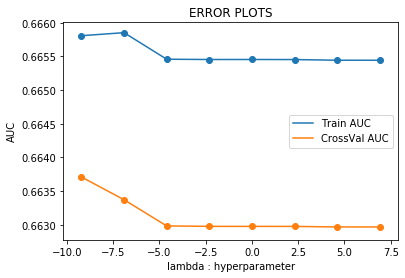

In [56]:
plt.plot(C, Train_AUC_BOW, label='Train AUC')
plt.scatter(C, Train_AUC_BOW)
plt.plot(C, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.scatter(C, CrossVal_AUC_BOW)
plt.legend()
plt.xlabel("lambda : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [57]:
optimal_inverse_lambda=c[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print(optimal_inverse_lambda)

0.0001


In [102]:
Classifier=LogisticRegression(C=optimal_inverse_lambda)
Classifier.fit(Train_BOW_mix,y_train)
Train_FPR, Train_TPR, Thresholds = roc_curve(y_train, Classifier.predict_proba(Train_BOW_mix)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(y_test, Classifier.predict_proba(Test_BOW_mix)[:,1])

C:\Users\SIDDHARTH\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


C:\Users\SIDDHARTH\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


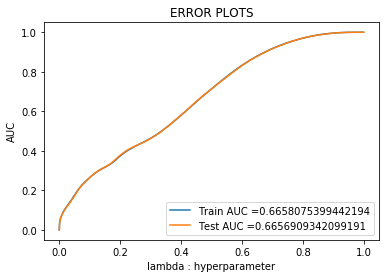

In [60]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.legend()
plt.xlabel("lambda : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [62]:
y_pred = Classifier.predict(Test_BOW_mix)

In [63]:
print(confusion_matrix(y_test, y_pred))
print('Accuracy of our model is: ', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[12376 39748]
 [ 4147 84549]]
Accuracy of our model is:  0.6882900156227808
              precision    recall  f1-score   support

           0       0.75      0.24      0.36     52124
           1       0.68      0.95      0.79     88696

    accuracy                           0.69    140820
   macro avg       0.71      0.60      0.58    140820
weighted avg       0.71      0.69      0.63    140820



In [103]:
feature_names = count.get_feature_names()
prob_sorted = sorted(zip(Classifier.coef_[0], feature_names))
print("Top 10 negative class words")
print(prob_sorted[:10])
print("Top 10 positive class words")
print(prob_sorted[:-(11):-1])

Top 10 negative class words
[(-0.060362920547825674, 'time'), (-0.0408857447915864, 'product'), (-0.034986237510186986, 'meet'), (-0.031738004515687104, 'new'), (-0.0297931836021813, 'us'), (-0.029613070877198895, 'inform'), (-0.029381713548403642, 'thank'), (-0.027295798212657645, 'work'), (-0.02671878605742858, 'need'), (-0.02581117278947182, 'last')]
Top 10 positive class words
[(0.011695532820607568, 'proposal'), (0.007013477995242535, 'conduct'), (0.0066020559267251, 'marketing'), (0.005993660499384265, 'accepted'), (0.0057505203124596505, 'looking'), (0.005745047476379108, 'reply'), (0.005466849587026959, 'percent'), (0.00468786134434446, 'responsiveness'), (0.00468786134434446, 'recommended'), (0.00468786134434446, 'provides')]


In [104]:
# Using L1 penalty

In [95]:
Classifier=LogisticRegression(C=optimal_inverse_lambda,penalty='l1', solver='liblinear' )
Classifier.fit(Train_BOW_mix,y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [96]:
y_pred = Classifier.predict(Test_BOW_mix)

In [97]:
print(confusion_matrix(y_test, y_pred))
print('Accuracy of our model is: ', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[12055 40069]
 [ 2920 85776]]
Accuracy of our model is:  0.6947237608294277
              precision    recall  f1-score   support

           0       0.81      0.23      0.36     52124
           1       0.68      0.97      0.80     88696

    accuracy                           0.69    140820
   macro avg       0.74      0.60      0.58    140820
weighted avg       0.73      0.69      0.64    140820



# TF-IDF

In [101]:
# TF-IDF vectorizer using l2 penalty

In [9]:
tf_idf=TfidfVectorizer(min_df=5,use_idf=True,ngram_range=(2,3))
tf_idf.fit(X_train)
Train_TFIDF = tf_idf.transform(X_train)
CrossVal_TFIDF = tf_idf.transform(X_cross)
Test_TFIDF= tf_idf.transform(X_test)

In [40]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000]
Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []
for i in c:
  logreg = LogisticRegression(C=i,penalty='l2')
  logreg.fit(Train_TFIDF, y_train)
  Train_y_pred =  logreg.predict_proba(Train_TFIDF)[:,1]
  Train_AUC_TFIDF.append(roc_auc_score(y_train,Train_y_pred))
  CrossVal_y_pred =  logreg.predict_proba(CrossVal_TFIDF)[:,1]
  CrossVal_AUC_TFIDF.append(roc_auc_score(y_cross,CrossVal_y_pred))

In [41]:
C=[]
for i in range(len(c)):
  C.append(np.math.log(c[i]))

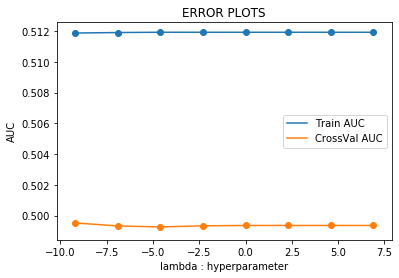

In [42]:
plt.plot(C, Train_AUC_TFIDF, label='Train AUC')
plt.scatter(C, Train_AUC_TFIDF)
plt.plot(C, CrossVal_AUC_TFIDF, label='CrossVal AUC')
plt.scatter(C, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel("lambda : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [43]:
optimal_inverse_lambda=c[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]

In [105]:
Classifier=LogisticRegression(C=optimal_inverse_lambda,penalty='l2')
Classifier.fit(Train_TFIDF, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
y_pred = Classifier.predict(Test_TFIDF)
print(confusion_matrix(y_test, y_pred))
print('Accuracy of our model is: ', accuracy_score(y_test, y_pred))

[[    0 52124]
 [    0 88696]]
Accuracy of our model is:  0.629853713961085


In [106]:
feature_names = tf_idf.get_feature_names()
prob_sorted = sorted(zip(Classifier.coef_[0], feature_names))
print("Top 10 negative class words")
print(prob_sorted[:10])
print("Top 10 positive class words")
print(prob_sorted[:-(11):-1])

Top 10 negative class words
[(-0.024799775957053283, 'able meet'), (-0.017176456961063787, 'product impressive'), (-0.017039263422046577, 'available call'), (-0.013880422263924663, 'deal closed'), (-0.012375533412350313, 'begin project'), (-0.012375533412350313, 'begin project soon'), (-0.012375533412350313, 'like begin'), (-0.012375533412350313, 'like begin project'), (-0.012375533412350313, 'possible look'), (-0.012375533412350313, 'possible look forward')]
Top 10 positive class words
[(0.054463681032613634, 'like proposal'), (0.026475346845924976, 'convinced idea'), (0.017085994395133176, 'proceed deal pricing'), (0.017085994395133176, 'proceed deal'), (0.017085994395133176, 'pricing high'), (0.017085994395133176, 'deal pricing high'), (0.017085994395133176, 'deal pricing'), (0.014405088142948726, 'accept proposal'), (0.012469120044095257, 'sure need product'), (0.012469120044095257, 'sure need')]


In [65]:
#Uisng Numeric Features as well

In [16]:
Train_TFIDF_mix = (hstack((Train_TFIDF,np.array(Train_agent)[:,None], np.array(Train_pdt)[:,None], np.array(Train_diff)[:,None], np.array(Train_val)[:,None]))).tocsr()

Cross_TFIDF_mix = (hstack((CrossVal_TFIDF,np.array(cross_agent)[:,None], np.array(cross_pdt)[:,None], np.array(cross_diff)[:,None], np.array(cross_val)[:,None]))).tocsr()

Test_TFIDF_mix = (hstack((Test_TFIDF,np.array(test_agent)[:,None], np.array(test_pdt)[:,None], np.array(test_diff)[:,None], np.array(test_val)[:,None]))).tocsr()

In [71]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000]
Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []
for i in c:
  logreg = LogisticRegression(C=i,penalty='l2')
  logreg.fit(Train_TFIDF_mix, y_train)
  Train_y_pred =  logreg.predict_proba(Train_TFIDF_mix)[:,1]
  Train_AUC_TFIDF.append(roc_auc_score(y_train,Train_y_pred))
  CrossVal_y_pred =  logreg.predict_proba(Cross_TFIDF_mix)[:,1]
  CrossVal_AUC_TFIDF.append(roc_auc_score(y_cross,CrossVal_y_pred))

In [72]:
C=[]
for i in range(len(c)):
  C.append(np.math.log(c[i]))

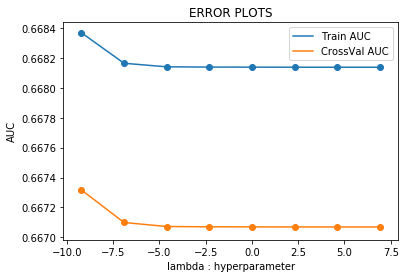

In [73]:
plt.plot(C, Train_AUC_TFIDF, label='Train AUC')
plt.scatter(C, Train_AUC_TFIDF)
plt.plot(C, CrossVal_AUC_TFIDF, label='CrossVal AUC')
plt.scatter(C, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel("lambda : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [75]:
optimal_inverse_lambda=c[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]

In [76]:
Classifier=LogisticRegression(C=optimal_inverse_lambda,penalty='l2')
Classifier.fit(Train_TFIDF_mix, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [77]:
y_pred = Classifier.predict(Test_TFIDF_mix)
print(confusion_matrix(y_test, y_pred))
print('Accuracy of our model is: ', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[13801 38323]
 [ 4069 84627]]
Accuracy of our model is:  0.6989632154523505
              precision    recall  f1-score   support

           0       0.77      0.26      0.39     52124
           1       0.69      0.95      0.80     88696

    accuracy                           0.70    140820
   macro avg       0.73      0.61      0.60    140820
weighted avg       0.72      0.70      0.65    140820



In [78]:
# Lets try using L1 Penalty

In [20]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000]
Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []
for i in c:
  logreg = LogisticRegression(C=i,penalty='l1',solver='liblinear')
  logreg.fit(Train_TFIDF_mix, y_train)
  Train_y_pred =  logreg.predict_proba(Train_TFIDF_mix)[:,1]
  Train_AUC_TFIDF.append(roc_auc_score(y_train,Train_y_pred))
  CrossVal_y_pred =  logreg.predict_proba(Cross_TFIDF_mix)[:,1]
  CrossVal_AUC_TFIDF.append(roc_auc_score(y_cross,CrossVal_y_pred))

KeyboardInterrupt: 

In [80]:
C=[]
for i in range(len(c)):
  C.append(np.math.log(c[i]))

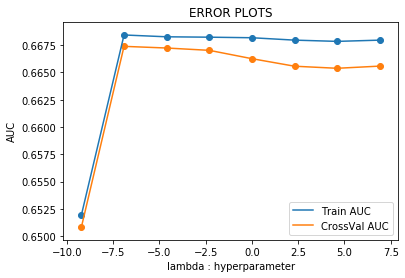

In [81]:
plt.plot(C, Train_AUC_TFIDF, label='Train AUC')
plt.scatter(C, Train_AUC_TFIDF)
plt.plot(C, CrossVal_AUC_TFIDF, label='CrossVal AUC')
plt.scatter(C, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel("lambda : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [82]:
optimal_inverse_lambda=c[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]

In [21]:
Classifier=LogisticRegression(C=0.001,penalty='l1', solver='liblinear')
Classifier.fit(Train_TFIDF_mix, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
y_pred = Classifier.predict(Test_TFIDF_mix)
print(confusion_matrix(y_test, y_pred))
print('Accuracy of our model is: ', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[12032 40092]
 [ 2931 85765]]
Accuracy of our model is:  0.6944823178525777
              precision    recall  f1-score   support

           0       0.80      0.23      0.36     52124
           1       0.68      0.97      0.80     88696

    accuracy                           0.69    140820
   macro avg       0.74      0.60      0.58    140820
weighted avg       0.73      0.69      0.64    140820



In [23]:
import pickle

In [24]:
pickle.dump(Classifier, open('text_model', 'wb'))

In [25]:
pickle.dump(tf_idf, open('vect_model', 'wb'))

### Final Table

In [99]:
x = PrettyTable()

x.field_names = ["VECTORIZER", "REGULARIZATION", "HYPER PARAMETER", "ACCURACY"]

x.add_row(["BOW","L2",0.0001,0.68829])
x.add_row(["BOW","L1",0.001, 0.6947])
x.add_row(["TFIDF","L2",0.0001,0.6989])
x.add_row(["TFIDF","L1",0.001,0.6946])
print(x)

+------------+----------------+-----------------+----------+
| VECTORIZER | REGULARIZATION | HYPER PARAMETER | ACCURACY |
+------------+----------------+-----------------+----------+
|    BOW     |       L2       |      0.0001     | 0.68829  |
|    BOW     |       L1       |      0.001      |  0.6947  |
|   TFIDF    |       L2       |      0.0001     |  0.6989  |
|   TFIDF    |       L1       |      0.001      |  0.6946  |
+------------+----------------+-----------------+----------+


Now we have a model which predicts whether a deal would be closed (Won) or Not (Lost).
I will choose the logistic regression model which uses a L1 penalty on the Tf-idf vectorizer to compute whether a deal would be closed or not.

I shall now build a model which predicts the close_value for a deal for unseen data